In [95]:

from ultralytics import YOLO
import pandas as pd
import re
import numpy as np
import cv2

In [96]:

def open_video(video_path):
    vid=list()
    cap=cv2.VideoCapture(video_path)
    frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    buf = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))
    fc=0
    while True:
        ret, frame = cap.read()
        if not ret: break # break if no next frame
        
        # buf[fc]=frame # append frame
        # fc+=1
        vid.append(frame)
    # release and destroy windows
    cap.release()
    cv2.destroyAllWindows()
    return vid


    

In [131]:
def detect(vid):
    model=YOLO('v1.pt')
    results=model(vid)
    res=list()
    df=pd.DataFrame(columns=["Frame","Class","Confidence","X1","Y1","X2","Y2","Xc","Yc","H","W"])
    for result in results:
        for box in result.boxes:
            xyxy=box.xyxy.numpy()[0]
            X=(xyxy[2]+xyxy[0])/2
            Y=(xyxy[3]+xyxy[1])/2
            frame_number=re.search('(?<=image)\d+',result.path).group()
            df.loc[len(df)]=[frame_number,"BAT" if box.cls==0 else "BALL",int(float(box.conf)*100),xyxy[0],xyxy[1],xyxy[2],xyxy[3],X,Y,abs(xyxy[2]-xyxy[0]),abs(xyxy[3]-xyxy[1])]
    return df

In [140]:
def suppress(detections):
    df=pd.DataFrame()
    
    return df

In [ ]:
def detect_impact_frame(detections):
    f_impact=0
    return f_impact

In [ ]:
def detect_bounce_frame(detections):
    b_bounce=0
    return b_bounce

In [132]:
vid=open_video('7.2.23/1.mp4')

In [133]:
detections=detect(vid)

Ultralytics YOLOv8.0.49  Python-3.9.15 torch-1.13.1+cpu CPU
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs

0: 736x1280 1 BT, 1: 736x1280 1 BT, 2: 736x1280 1 BT, 3: 736x1280 1 BT, 4: 736x1280 1 BT, 5: 736x1280 1 BT, 6: 736x1280 1 BT, 7: 736x1280 1 BT, 8: 736x1280 1 BT, 9: 736x1280 1 BT, 10: 736x1280 1 BT, 11: 736x1280 1 BT, 12: 736x1280 2 BTs, 13: 736x1280 1 BT, 14: 736x1280 2 BTs, 15: 736x1280 1 BT, 16: 736x1280 1 BT, 17: 736x1280 1 BT, 18: 736x1280 2 BTs, 1 Ball, 19: 736x1280 1 BT, 1 Ball, 20: 736x1280 1 BT, 1 Ball, 21: 736x1280 1 BT, 1 Ball, 22: 736x1280 1 BT, 1 Ball, 23: 736x1280 1 BT, 1 Ball, 24: 736x1280 1 BT, 1 Ball, 25: 736x1280 1 BT, 1 Ball, 26: 736x1280 1 BT, 1 Ball, 27: 736x1280 1 BT, 1 Ball, 28: 736x1280 1 BT, 1 Ball, 29: 736x1280 1 BT, 30: 736x1280 1 BT, 1 Ball, 31: 736x1280 1 BT, 1 Ball, 32: 736x1280 1 BT, 1 Ball, 33: 736x1280 2 BTs, 1 Ball, 34: 736x1280 1 BT, 21002.6ms
Speed: 6.7ms preprocess, 600.1ms inference, 2.0ms postprocess per image

In [134]:
detections

,Frame,Class,Confidence,X1,Y1,...,Y2,Xc,Yc,H,W
0,0,BAT,60,904.0,267.0,...,307.0,928.5,287.0,49.0,40.0
1,1,BAT,61,902.0,265.0,...,308.0,927.5,286.5,51.0,43.0
2,2,BAT,60,900.0,263.0,...,309.0,925.5,286.0,51.0,46.0
3,3,BAT,59,899.0,260.0,...,311.0,924.5,285.5,51.0,51.0
4,4,BAT,61,897.0,257.0,...,307.0,922.0,282.0,50.0,50.0
5,5,BAT,62,897.0,254.0,...,311.0,921.0,282.5,48.0,57.0
6,6,BAT,64,895.0,248.0,...,310.0,919.5,279.0,49.0,62.0
7,7,BAT,64,893.0,242.0,...,310.0,918.0,276.0,50.0,68.0
8,8,BAT,62,892.0,237.0,...,306.0,916.5,271.5,49.0,69.0
9,9,BAT,63,892.0,234.0,...,305.0,916.5,269.5,49.0,71.0


In [135]:
ball=detections.loc[detections["Class"]=="BALL"]

In [142]:
ball

,Frame,Class,Confidence,X1,Y1,...,Y2,Xc,Yc,H,W
20,18,BALL,84,844.0,551.0,...,565.0,850.0,558.0,12.0,14.0
23,19,BALL,85,848.0,571.0,...,585.0,854.5,578.0,13.0,14.0
25,20,BALL,88,853.0,597.0,...,612.0,859.5,604.5,13.0,15.0
27,21,BALL,75,857.0,629.0,...,645.0,864.5,637.0,15.0,16.0
29,22,BALL,88,863.0,669.0,...,685.0,870.0,677.0,14.0,16.0
31,23,BALL,81,869.0,715.0,...,732.0,877.0,723.5,16.0,17.0
33,24,BALL,86,877.0,697.0,...,714.0,885.0,705.5,16.0,17.0
35,25,BALL,86,883.0,654.0,...,670.0,891.0,662.0,16.0,16.0
38,26,BALL,81,893.0,610.0,...,628.0,902.0,619.0,18.0,18.0
40,27,BALL,44,901.0,569.0,...,586.0,910.0,577.5,18.0,17.0


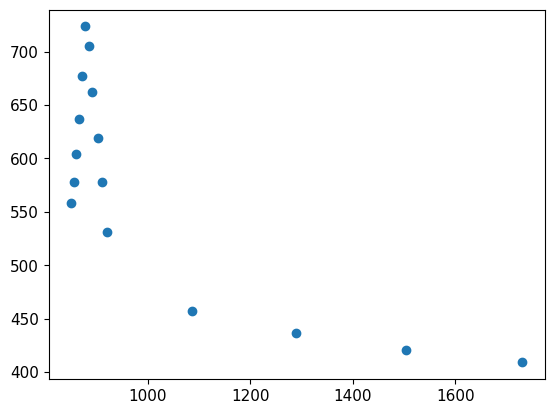

In [143]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(ball["Xc"],ball["Yc"])
plt.show()
